In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
def get_raw_data(year):
    """
    Read in SPY_{year}.csv
    create datetime index
    convert to US/Eastern timezone
    trim to trading hours
    """
    df = pd.read_csv('./Polygon/Raw/SPY_{}.csv'.format(year), engine='c', index_col=['t'], usecols = ['t','p','s'], dtype={'t':np.int64, 'p':np.float64, 's':np.float64})
    #convert index to pd.DatetimeIndex, timezone naive, daylight savings naive
    df.index = pd.to_datetime(df.index, unit='ns')
    #convert index to US-Eastern timezone, automatically takes care of daylight savings
    df.index = df.index.tz_localize('UTC').tz_convert('US/Eastern')
    #restrict data to trading hours
    df = df.between_time('09:30:00', '16:00:00')
    #remove outliers = pct change >= 1%
    df = df.groupby(pd.Grouper(freq='D'),as_index=False).apply(lambda g: g[abs(((g.p.shift(1)-g.p) / g.p) < 0.01)])
    return df

def strided_window(a, window_size, step_size):
    """
    Create expanded array of references that effectively create a "memory" for each row,
    where columns are previous rows' data.
    See generate_view() for information on what window_size and step_size are
    https://stackoverflow.com/questions/40084931/taking-subarrays-from-numpy-array-with-given-stride-stepsize/40085052#40085052
    """
    nrows = ((a.size-window_size)//step_size)+1
    n     = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,window_size), strides=(step_size*n,n), writeable=False)

def generate_view(aggregated_data, lookback):
    """
    Generates numpy view of ohlcv_data with shape (nrows-lookback, ncols*lookback)
    :ohlcv_data: a contiguous numpy array with shape (n,m)
    :lookback: an integer specifying how many periods to include in each row
    """
    ncols = aggregated_data.shape[1]
    data  = aggregated_data.ravel()
    #get views (references) of prices (no copying, no extra memory)
    data_strided = strided_window(data, window_size = lookback*ncols, step_size = ncols)
    return data_strided[:-1]

def calc_ohlcv(df, period):
    #period = microseconds(U) | milliseconds(L) | seconds(S) | minutes(T) | hour(H)
    temp = df.resample(period).agg({'p': 'ohlc', 's': 'sum'})
    temp.columns = ['open','high','low','close','volume']
    temp['close'].fillna(method='ffill', inplace=True)
    temp['open'].fillna(temp['close'], inplace=True)
    temp['high'].fillna(temp['close'], inplace=True)
    temp['low'].fillna(temp['close'], inplace=True)
    return temp

def OHLCV_generator(year, resample_freq = 'T', measure = 'high', lookback_memory = 1):
    try: #need this for args passed by tf.data.Dataset.from_generator
        resample_freq = resample_freq.decode("utf-8") 
        measure       = measure.decode("utf-8") 
    except:
        pass
    spy = get_raw_data(year)
    for day, day_group in spy.groupby(pd.Grouper(freq='D')):
        #get ohlcv data
        ohlcv_temp = calc_ohlcv(day_group, resample_freq)
        #take measure as outcome
        Ytrain = ohlcv_temp[measure].values[lookback_memory:]
        #generate training data
        Xtrain = generate_view(ohlcv_temp.values, lookback_memory)
        for i in range(Xtrain.shape[0]):
            yield Xtrain[i], Ytrain[i]

def bivariate_generator(year, resample_freq = 'ms'):
    spy = get_raw_data(year)
    for day, day_group in spy.groupby(pd.Grouper(freq='D')):
        print('\r{}...'.format(day), end='')
        #market price at second = x = most recent price = bin using prices up to and including x
        #each day = 1GB on disk, 560MB in RAM
        bivariate = day_group.resample(resample_freq, label='right',closed='right').agg({'p':'last','s':'sum'}).ffill()
        #for price in last_bids.values:
        yield last_bids.values
        break

In [43]:
i = 0
for x in last_bid_generator(2003, resample_freq = 'ms'):
    i += 1
i

2003-12-01 00:00:00-05:00...

23390752

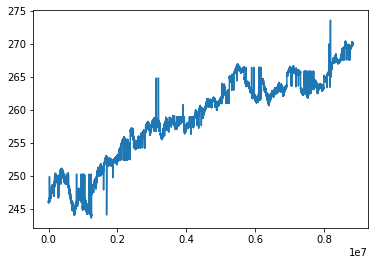

In [191]:
plt.plot(df2.p) # plotting by columns
plt.show()

In [ ]:
YEAR = 2003
FREQ = 'T'
MSR  = 'close'
MEM  = 2
price_generator = tf.data.Dataset.from_generator(
                    generator     = ohlcv_generator, args=[YEAR,FREQ,MSR,MEM], 
                    output_types  = (tf.float32, tf.float32),
                    output_shapes =(tf.TensorShape([5*MEM]), tf.TensorShape([]))).repeat().batch(8).prefetch(8)
     
price_generator

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Dense(32, input_shape=(5*MEM,)),
                             tf.keras.layers.Dense(64, activation=tf.nn.tanh),
                             tf.keras.layers.Dense(12, activation=tf.nn.softmax),
                             tf.keras.layers.Dense(32, activation=tf.nn.tanh),
                             tf.keras.layers.Dense(1, activation=tf.nn.relu)])

model.compile(optimizer='adam',
              loss='mean_absolute_error')

model.fit(price_generator, epochs=5, steps_per_epoch=8347)

In [ ]:
#only works on 1D data (predict high based off prev highs only)
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=(1,5)),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

simple_lstm_model.fit(mydataset, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL)